# Logistic Regression with a Neural Network mindset


## Table of Contents
- [1 - Packages](#1)
- [2 - Overview](#2)
- [3 - General Architecture of the learning algorithm](#3)
- [4 - Building the parts of our algorithm](#4)
    - [4.1 - Helper functions](#4-1)
    - [4.2 - Initializing parameters](#4-2)
    - [4.3 - Forward and Backward propagation](#4-3)
    - [4.4 - Optimization](#4-4)
- [5 - Merge all functions into a model](#5)
- [6 - Further analysis to tune learning rate](#6)

<a name='1'></a>
## 1 - Packages ##


In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
from public_tests import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
## 2 - Overview##


In [ ]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


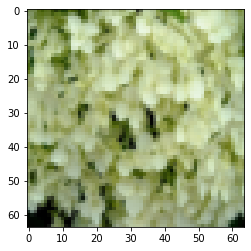

In [ ]:
# Example of a picture
index = 98
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [ ]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [ ]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<a name='3'></a>
## 3 - General Architecture of the learning algorithm ##

A Logistic Regression classifier can actually be thought of as a very simple Neural Network.

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

<a name='4'></a>
## 4 - Building the parts of our algorithm ##

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

<a name='4-1'></a>
### 4.1 - Helper functions

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1/(1+np.exp(-z))

    return s

In [ ]:
x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)

[0.62245933 0.5        0.88079708]


<a name='4-2'></a>
### 4.2 - Initializing parameters


In [ ]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """

    w = np.zeros((dim, 1))
    b = 0.0

    return w, b

<a name='4-3'></a>
### 4.3 - Forward and Backward propagation

Forward Propagation:
- We get X
- We compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- We calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$


$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

In [ ]:
# print(Y.shape)
# print(A.shape)

In [ ]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    """

    m = X.shape[1]

    # compute activation
    A = sigmoid(np.dot(w.T, X) + b)
    print('Y shape', Y.shape)
    print('log A shape', np.log(A).shape)
    cost = -(1/m)*((np.dot(Y, np.log(A).T)) + np.dot((1-Y), np.log(1-A).T))

    # BACKWARD PROPAGATION (TO FIND GRAD)
    #(≈ 2 lines of code)
    dw = (1/m)*(np.dot(X, (A-Y).T))
    db = (1/m)*np.sum(A-Y)

    cost = np.squeeze(np.array(cost))


    grads = {"dw": dw,
             "db": db}

    return grads, cost

<a name='4-4'></a>
### 4.4 - Optimization

In [ ]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    costs = []
    for i in range(num_iterations):
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [ ]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    print(A)

    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0][i] > 0.5:
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0

    return Y_prediction

<a name='5'></a>
## 5 - Merge all functions into a model ##

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """
    w, b = initialize_with_zeros(X_train.shape[0])
    print('X_train shape:', X_train.shape)

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "params"
    w = parameters['w']
    b = parameters['b']

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [ ]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

X_train shape: (12288, 209)
Y shape (1, 209)
log A shape (1, 209)
Cost after iteration 0: 0.693147
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shap

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Cost after iteration 1100: 0.203078
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 20

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Cost after iteration 1300: 0.183033
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 20

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

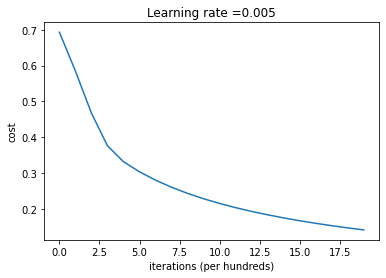

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

<a name='6'></a>
## 6 - Further analysis##


#### Choice of learning rate ####


Training a model with learning rate: 0.01
X_train shape: (12288, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
l

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 209)
log A shape (1, 209)
Y shape (1, 

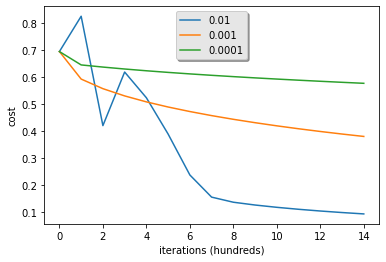

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()